In [1]:
!pip install diffprivlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
import time
import psutil

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

     |████████████████████████████████| 81kB 3.8MB/s 
  Created wheel for diffprivlib: filename=diffprivlib-0.4.1-cp36-none-any.whl size=153527 sha256=aef20fcf98e21f234f2f9f402ab4a0f9f17428c6ea59746a5dff4f3b7570e9cd
  Stored in directory: /root/.cache/pip/wheels/76/55/d3/be3c4635eecedcf48e196272b356c2b3bd11460962fc952e1b
Successfully built diffprivlib


In [2]:
start_time = time.time()
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/o-ring-erosion-or-blowby.data'
column_names = ['Number of O-rings at risk on a given flight', 'Number experiencing thermal distress', 'Launch temperature (degrees F)', 'Leak-check pressure (psi)', 'Temporal order of flight']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)


In [3]:
dataset = raw_dataset.copy()

In [4]:
dataset = dataset.dropna()
dataset

,Number of O-rings at risk on a given flight,Number experiencing thermal distress,Launch temperature (degrees F),Leak-check pressure (psi),Temporal order of flight
0,6,0,66,50,1
1,6,1,70,50,2
2,6,0,69,50,3
3,6,0,68,50,4
4,6,0,67,50,5
5,6,0,72,50,6
6,6,0,73,100,7
7,6,0,70,100,8
8,6,1,57,200,9
9,6,1,63,200,10


In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


In [6]:
X_train = train_dataset.copy()
X_test = test_dataset.copy()

y_train = X_train.pop('Launch temperature (degrees F)')
y_test = X_test.pop('Launch temperature (degrees F)')


In [7]:
from sklearn.linear_model import LinearRegression as sk_LinearRegression

regr = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('clf', sk_LinearRegression()) 
])

regr.fit(X_train, y_train)

baseline = regr.score(X_test, y_test)
print("Non-private baseline R2 score: %.2f" % baseline)


Non-private baseline R2 score: 0.47


In [8]:
from diffprivlib.models import LinearRegression
dp_regr = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('clf', LinearRegression(epsilon=float('inf'))) 
])

dp_regr.fit(X_train, y_train)

baseline2 = dp_regr.score(X_test, y_test)
print("private baseline R2 score: %.2f" % baseline2)


private baseline R2 score: 0.47


/usr/local/lib/python3.6/dist-packages/diffprivlib/models/linear_regression.py:258: PrivacyLeakWarning: Bounds parameters haven't been specified, so falling back to determining bounds from the data.
This will result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `bounds_X` and `bounds_y`.
  PrivacyLeakWarning)


In [9]:
epsilons = np.logspace(-3, 2, 500)
accuracy = []
cpu_Overhead = []
mem_Overhead = []

for epsilon in epsilons:
    dp_regr.fit(X_train, y_train)

    cpu_Overhead.append(psutil.cpu_percent())
    psutil.virtual_memory()
    dict(psutil.virtual_memory()._asdict())
    mem_Overhead.append(psutil.virtual_memory().percent)   

    accuracy.append(dp_regr.score(X_test, y_test))

--- 4.954740524291992 seconds ---


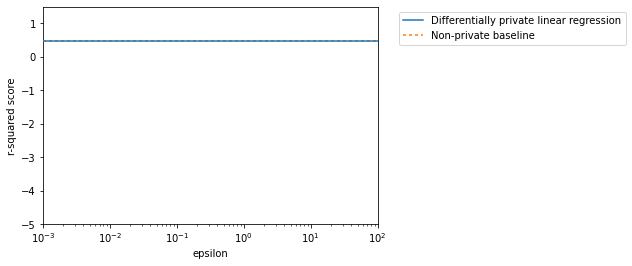

In [10]:
print("--- %s seconds ---" % (time.time() - start_time))
plt.semilogx(epsilons, accuracy, label="Differentially private linear regression", zorder=10)
plt.semilogx(epsilons, baseline * np.ones_like(epsilons), dashes=[2,2], label="Non-private baseline", zorder=5)
plt.xlabel("epsilon")
plt.ylabel("r-squared score")
plt.ylim(-5, 1.5)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [11]:
print(sum((cpu_Overhead))/500)
print(sum((mem_Overhead))/500)

47.52020000000001
6.3000000000000425


In [12]:
accuracy_final1 = []
for _ in " "*10: 
  dp_regr.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final1.append(dp_regr.score(X_test, y_test))


In [13]:
accuracy_final01 = []
for _ in " "*10: 
  dp_regr.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final01.append(dp_regr.score(X_test, y_test))


In [14]:
accuracy_final001 = []
for _ in " "*10: 
  dp_regr.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final001.append(dp_regr.score(X_test, y_test))


In [15]:
accuracy_final = []
#accuracy_final1.remove(max(accuracy_final1))
#accuracy_final1.remove(min(accuracy_final1))

#accuracy_final01.remove(max(accuracy_final01))
#accuracy_final01.remove(min(accuracy_final01))

#accuracy_final001.remove(max(accuracy_final001))
#accuracy_final001.remove(min(accuracy_final001))

accuracy_final.append(sum(accuracy_final1)/10)
accuracy_final.append(sum(accuracy_final01)/10)
accuracy_final.append(sum(accuracy_final001)/10)

In [16]:
accuracy_final

[-679271411.3382682, -376496554.509255, -132961319.81969014]

In [17]:
accuracy_NP = []
for _ in " "*10: 
  regr.fit(X_train, y_train) 
  accuracy_NP.append(regr.score(X_test, y_test))

In [18]:
print(sum(accuracy_NP)/10)

0.47490140437194006
